# Schrieffer Wolff Transformation for a triple quantum dot


We carry out the second order BW perturbation theory for a quantum dot with 3 spinful orbitals.

In [18]:
import numpy as np
from MesoPack.MesoPack import InitHam, Operators, SuperBlockDiagonalization, SuperBlockOperator
import itertools as it
import matplotlib.pyplot as plt

In [19]:
def bin_decomp(x):
    #x += 4
    x1 = x//2
    x2 = int(2*(x/2-x//2))
    return (x1,x2)

In [20]:
def fermi_parent(T):
    def fermi(x):
        return 1./(1+np.exp(x/T))
    return fermi

In [21]:
# pauli matrices
PMx = np.array([[0.,1.],[1.,0.]])
PMy = np.array([[0.,-1.j],[1.j,0.]])
PMz = np.array([[1.,0.],[0.,-1.]])
delta = np.array([[1.,0.],[0.,1.]])
pli = [PMx,PMy,PMz,delta]

# pauli tensor
pauli_tensor = np.zeros((2,2,2,2),dtype=complex)
delta_tensor  = np.zeros((2,2,2,2),dtype=complex)
for n in range(3):
    for (a,b,c,d) in it.product([0,1], repeat=4):
        pauli_tensor[a,b,c,d] += pli[n][a,b]*pli[n][c,d]
        if n == 0: delta_tensor[a,b,c,d] += delta[a,b]*delta[c,d]

# test overlap
trace = 0.
n1 = 0
n2 = 2
for (a,b,c,d) in it.product([0,1], repeat=4):
    trace += pli[n1][a,b]*pli[n1][c,d]*pli[n2][a,b]*pli[n2][c,d]
print("overlap: ",trace)
trace = 0.
n2 = 2
for (a,b,c,d) in it.product([0,1], repeat=4):
    trace += delta[a,b]*delta[c,d]*pli[n2][a,b]*pli[n2][c,d]
print("overlap: ",trace)

overlap:  0.0
overlap:  0.0


## Hamiltonian

Here we consider the TQD model $\hat{H}=\hat{H}_{\rm leads}+\hat{H}_{\rm TQD}+\hat{H}_{\rm hyb}$, with
$$
\hat{H}_{\rm TQD} = \sum_{j=1,2,3} \left ( \epsilon_j \hat{n}_j + U_j \hat{n}_{j\uparrow}\hat{n}_{j\downarrow} \right )  + %\\ 
\sum_{i\ne j} \left (U_{ij}'\hat{n}_i\hat{n}_j   + \sum_{\sigma} t_{ij}^{\phantom{\dagger}} \hat{d}^{\dagger}_{i\sigma}\hat{d}^{\phantom{\dagger}}_{j\sigma} \right) \;,
$$
where $\hat{n}_j=\sum_{\sigma}\hat{n}_{j\sigma}$, and the inter-dot tunnelling matrix elements satisfy $t_{ij}=t_{ji}^*$. We take for simplicity equivalent dots with $\epsilon_j\equiv \epsilon$, $U_j\equiv U$, $U'_{ij}\equiv U'$, and consider the mirror symmetric case $t_{12}=t_{13}\equiv t$ but $t_{23}\equiv t'$. We consider the following TQD-lead hybridization,
$$
		\hat{H}_{\rm hyb} = \sum_{\sigma} \left (V_s^{\phantom{\dagger}} \hat{d}^{\dagger}_{2\sigma}\hat{c}_{s\sigma}^{\phantom{\dagger}}+V_d^{\phantom{\dagger}} \hat{d}^{\dagger}_{3\sigma}\hat{c}_{d\sigma}^{\phantom{\dagger}} + h.c.\right ) \;.
$$

In [22]:
U = .5
V = 0.05
t = -U/(2*np.pi)
N = 3
DOF = [4 for _ in range(N)]
bDOF = [35 for _ in range(1)]

p = {}
# [("hubbard-U",1),("extended-hubbard-U",1),("epsilon",1),("hopping",1),("magfield",1),("spin-spin",2)]
# the epsilon and U are to follow the order of the DOF
p["hubbard-U"] = np.array([U for _ in range(N)])
p["extended-hubbard-U"] = np.array([0.*U for _ in range(N)]) 
p["epsilon"] = np.array([ 0. for _ in range(N)]) 
# the J and hopping are to follow the order of the bonds
p["spin-spin"] = np.array([[0.,0.] for _ in range(N)])
p["hopping"] = np.array([t,t,t])
# creating the Hamiltonain class
H = InitHam(DOF,bonds = [[1,0],[0,2],[1,2]])#,boundary_condition=bc_set)#,boson_DOF = bDOF)
ham = H.getH(p)
# for adjusting the 
# get the neutral hamiltonian matrix
ham_neutral = H.getH(p)
q = {}
# get the chemical potential matrix
q["epsilon"] = np.array([1. for i in range(N)]) #-.15
n_all = H.getH(q)
q = {}
# get the magnetization matrix
q["spin-spin"] = np.array([[1.,0.] for _ in range(N)])
sz_all = H.getH(q)
#print(ham.GetMat(0,False))

The Hilbert space of dimension  64  is initialized


We diagonalize the Hamiltonian in a broad gate voltage range to determien how the filling numbers in a certain voltage range.

In [23]:
eps_set = np.linspace(-1,0,100)
temp_set = np.logspace(-10,0,2)
occupation = np.zeros((100,2))
magnetization = np.zeros((100,2))
degeneracy = np.zeros(100)
for i,eps in enumerate(eps_set):
    eps_ham = n_all.copy()
    eps_ham.ScalarDot(eps)
    eps_ham.OperatorSum(ham)
    # diagonalize 
    a, b = eps_ham.Diagonalize(False,verbosity=0)
    # count degeneracy
    # initial bad guess for GS eneergy
    GS_temp_en = 10.
    # collect degenerate ground state qunatum numbers
    GS_QNset = []
    # tollerance to ground state energy fro GS set
    GS_tollerance = 1e-2
    for j,en in enumerate(a):
        # creating a set containing the ground state quantum numbers
        if en[1][0] < GS_temp_en-GS_tollerance:
            GS_temp_en = en[1][0]
            GS_QNset = [en[0]]
        elif en[1][0]  < GS_temp_en+GS_tollerance and en[1][0]  > GS_temp_en-GS_tollerance:
            GS_QNset += [en[0]]
    # print("GS quantum numbers: ",GS_QNset,"\n")
    degeneracy[i] = len(GS_QNset)
    # loop over tempearture
    for tind,temp in enumerate(temp_set):
        # setting the fermi function
        fd = fermi_parent(temp)
        # impurity partition function
        Z0 = sum([np.sum(np.exp(-x[1]/temp)) for x in a])
        # compute occupation
        occupation[i,tind] = sum([np.sum(np.diag(n_all.BraKetDot(x,x)[1])*np.exp(-y[1]/temp)/Z0) for x,y in zip(b,a)])
        magnetization[i,tind] = sum([np.sum(np.diag(sz_all.BraKetDot(x,x)[1])*np.exp(-y[1]/temp)/Z0) for x,y in zip(b,a)])

Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators were summed
Operators 

Text(0, 0.5, 'occupation')

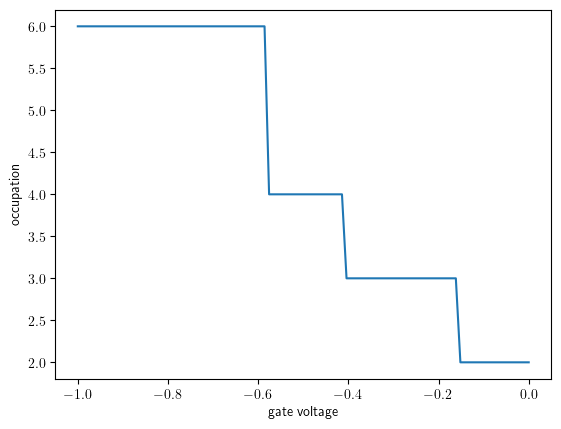

In [24]:
plt.plot(eps_set,occupation[:,0])
plt.xlabel("gate voltage")
plt.ylabel("occupation")

### Parity and cration-/anihilation operators

In [25]:
# #####################
# # initializing operators
# #####################
# # initializing the observables
SysObs = Operators(H)
# # constructing the observables
# # for the source lead
cd_0_up = SysObs.creation(0,"up")
c_0_up = SysObs.anihilation(0,"up")
cd_0_do = SysObs.creation(0,"down")
c_0_do = SysObs.anihilation(0,"down")
# for the source lead
cd_2_up = SysObs.creation(N-1,"up")
c_2_up = SysObs.anihilation(N-1,"up")
cd_2_do = SysObs.creation(N-1,"down")
c_2_do = SysObs.anihilation(N-1,"down")

In [26]:
#####
# total SU(2) spin symmetry
#####
Stot = SysObs.Stot()
#####
# parity symmetry
#####
# parity dictionary: 
# 0 <-> 1 can be flipped
par_dict = {1:2}
#parity operator
parity = SysObs.Parity(par_dict)
test_par = []
for i,j in enumerate(H.qnind):
    test_par += [parity.GetMat(i,False)]


## Test commutation

We test if the parity symmetry and the Hamiltonian commute

In [27]:
test_ham = []
for j,i in enumerate(H.qnind):
    test_ham += [ham.GetMat(j,False)]

noerror = True
for j,i in enumerate(H.qnind):
    A = np.dot(test_ham[j],test_par[j])
    B = np.dot(test_par[j],test_ham[j])
    if abs(np.max(abs((A-B).flatten()))) > 0.:
        print(i," does not commute")
        noerror = False
if noerror:
    print("all commutes")

all commutes


## Diagonalization

Check the degeneracy in the selected voltage range to determine the appropriate Schrieffer Wolff Transformation

In [28]:
n_points = 3
eps_set = np.linspace(-0.4,-0.2,n_points)#np.linspace(-43,-36,n_points)
degeneracy = np.zeros(n_points)
list_GS_QNset = []
for i,eps in enumerate(eps_set):
    print(eps)
    eps_ham = n_all.copy()
    eps_ham.ScalarDot(eps)
    eps_ham.OperatorSum(ham)
    # diagonalize
    _,_,_,GS_QNset = SuperBlockDiagonalization([parity,Stot],eps_ham,BlockOperator=False)
    #par_ham_val,par_ham_vec,new_ham_qn_dict,GS_QNset = BlockDiagonalization(Pval,Pvec,eps_ham)
    # collect degenerate ground state qunatum
    degeneracy[i] = len(GS_QNset)
    list_GS_QNset += [GS_QNset]

-0.4
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
-0.30000000000000004
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
-0.2
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']


Text(0, 0.5, 'ground state degeneracy')

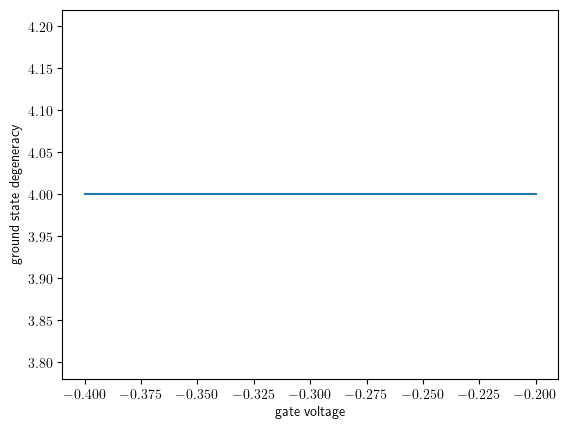

In [29]:
plt.plot(eps_set,degeneracy)
plt.xlabel("gate voltage")
plt.ylabel("ground state degeneracy")

## Schrieffer Wolff transformation

As a first step of the Schrieffer Wolff transformation we must decompose the creation and annihilation operators of frontier orbitals into quantum number blocks.

In [30]:
##################
# choose defining symmetries
##################
symmetry_set = [parity,Stot]
##############
# checking the commutaiton
##############
noerror = True
for A in symmetry_set+[ham]:
    for B in symmetry_set+[ham]:
        for i,j in enumerate(H.qnind):
            tmpA = A.GetMat(i,False)
            tmpB = B.GetMat(i,False)
            L = np.dot(tmpA,tmpB)
            R = np.dot(tmpB,tmpA)
            if abs(np.max(abs((L-R).flatten()))) > 1e-12:
                print(np.max(abs((L-R).flatten())))
                print(i," does not commute")
                noerror = False
                break
##############
# decompose operators into symmetry blocks
##############
if noerror:
    print("all commutes")
    ###############
    # get all ingredients for the SuperBlockOperator
    ###############
    _,_,_,Tot_QN_set,basistrafos,basis_dict_set,_ = SuperBlockDiagonalization(symmetry_set,ham)
    # creation
    cd_0_up_set,cd_0_up_dict,cd_0_up_out =  SuperBlockOperator(basistrafos,basis_dict_set,cd_0_up)
    cd_0_do_set,cd_0_do_dict,cd_0_do_out =  SuperBlockOperator(basistrafos,basis_dict_set,cd_0_do)
    cd_2_up_set,cd_2_up_dict,cd_2_up_out =  SuperBlockOperator(basistrafos,basis_dict_set,cd_2_up)
    cd_2_do_set,cd_2_do_dict,cd_2_do_out =  SuperBlockOperator(basistrafos,basis_dict_set,cd_2_do)
    all_cd_sets = [cd_0_up_set,cd_0_do_set,cd_2_up_set,cd_2_do_set]
    all_cd_dict = [cd_0_up_dict,cd_0_do_dict,cd_2_up_dict,cd_2_do_dict]
    all_cd_out = [cd_0_up_out,cd_0_do_out,cd_2_up_out,cd_2_do_out]
    # anihilation
    c_0_up_set,c_0_up_dict,c_0_up_out = SuperBlockOperator(basistrafos,basis_dict_set,c_0_up)
    c_0_do_set,c_0_do_dict,c_0_do_out = SuperBlockOperator(basistrafos,basis_dict_set,c_0_do)
    c_2_up_set,c_2_up_dict,c_2_up_out = SuperBlockOperator(basistrafos,basis_dict_set,c_2_up)
    c_2_do_set,c_2_do_dict,c_2_do_out = SuperBlockOperator(basistrafos,basis_dict_set,c_2_do)
    all_c_sets = [c_0_up_set,c_0_do_set,c_2_up_set,c_2_do_set]
    all_c_dict = [c_0_up_dict,c_0_do_dict,c_2_up_dict,c_2_do_dict]
    all_c_out = [c_0_up_out,c_0_do_out,c_2_up_out,c_2_do_out]
    # QN set
    all_cd_index = [[0,1],[0,0],[1,1],[1,0]]

all commutes
GS quantum numbers:  ['Q-1S0S1.00S0.00']


In the following for simplicity of the discussion, we assume that all states can be labelled by a unique combination of quantum numbers and thus, we omit the multiplet index henceforth. The occupation $N = \bra{\mathbf{Q},\mathbf{q}}\hat{N}_{\rm mol} \ket{\mathbf{Q},\mathbf{q}}$ (or charge $Q = eN$) is a conserved quantity and defining an abelian quantum number. Because of its importance we state it before the non-abelian \qn{}s
$$
	\ket{n} \mapsto \ket{N,\mathbf{Q},\mathbf{q}}\;, %\\
	%\textrm{with}~\mathbf{Q} \equiv (Q_1,Q_2,\dots),~\mathbf{q} \equiv (q_1,q_2,\dots)
$$
We demand that the molecule is tuned to a \gs{} manifold with integer occupation $N$
$$
\ket{GS} = \ket{N,\mathbf{Q}_{GS},\mathbf{q}}\;,\\
\textrm{with}~(q_1,q_2,\dots)\in \mathbb{q}_{GS} \equiv \lbrace (q'_1,q'_2,\dots),(q''_1,q''_2,\dots),\dots \rbrace \;,
$$
where we have assumed that the GS manifold is defined by a fixed set of non-abelian QNs $\mathbf{Q}_{GS}$ and a number of different abelian \qn{} sets $\mathbb{q}_{GS}$. The goal of the BWPT is to derive an effective model that is defined only on the GS manifold of the molecule (but including the entire Fock space of the leads), the GS manifold thus defines the model space
$$
	\hat{M} = \sum_{\mathbf{q}\in \mathbb{q}_{GS}} \ket{N,\mathbf{Q}_{GS},\mathbf{q}}\bra{N,\mathbf{Q}_{GS},\mathbf{q}} \bigotimes_\alpha\left(\sum_k\ket{k}_\alpha ~_\alpha\bra{k}\right)  \;,
$$
with its defining property
$$
	(\hat{H}_{\rm mol} + \hat{H}_{\rm gate})\hat{M} = E_{G} \hat{M} \; ,
$$
where $E_{G}$ is the \gs{} energy of $\hat{H}_0$. Using this the generalized SWT effective exchange Hamiltonian is to second order in $\hat{H}_{\rm hyb}$
$$
	\hat{H}_{\rm eff} = \sum_\alpha\hat{H}^\alpha_{\rm bath} + \hat{H}_{\rm ex} \\  \hat{H}_{\rm ex} = \sum_{\alpha\alpha'}\hat{M} \left[\hat{H}^{\alpha}_{\rm hyb} \hat{O} \frac{1}{E_{G} - (\hat{H}_{\rm mol}+\hat{H}_{\rm gate})} \hat{O} \hat{H}^{\alpha'}_{\rm hyb}  \right] \hat{M} \; ,
$$
where the conjugate space is $\hat{O} = \hat{\mathbb{1}} - \hat{M}$. To simplify the notation we combine all orbitals of the impurity, which hybridize with lead $\alpha$, in to a frontier orbital
$$
	\bar{\hat{d}}^\dagger_{\alpha\sigma} = \frac{1}{V_\alpha}\sum_i V_{\alpha i}\hat{d}^\dagger_{i\sigma} \; ,
$$
with $V^2_\alpha = \sum_i |V_{\alpha i }|^2$, while $\hat{c}_{\alpha\sigma 0}$ remain the frontier orbitals of the leads.
When inserting the equations the exchange Hamiltonian can be expressed as
$$
	\hat{H}_{\rm ex} = \sum_{\substack{\alpha\alpha' \\ \sigma\sigma'}}V_{\alpha}V_{\alpha'}\hat{c}^\dagger_{\alpha 0 \sigma}\hat{c}_{\alpha' 0 \sigma'}\sum_{\mathbf{q},\mathbf{q}' \in \mathbb{q}_{GS}} A^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots} \ket{N,\mathbf{Q}_{GS},\mathbf{q}}\bra{N,\mathbf{Q}_{GS},\mathbf{q}'} \; ,
$$
where we have introduced the cotunnelling amplitude $A^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots}$. 
The hybridization term either adds (by means of $\bar{\hat{d}}^\dagger_\alpha$) or removes (by means of $\bar{\hat{d}}_\alpha$) an electron from the molecule. The full cotunnelling amplitude can be decomposed in to the contribution from creating an electron (partiitcle $p$) and destroying an electron (hole $h$) 
$$
	A^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots} = h^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots} + p^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots} \;.
$$
The particle and hole contributions are respectively given gy
$$
	h^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots} = \sum_{\tilde{\mathbf{q}},\tilde{\mathbf{Q}}} 
	\frac{\bra{N,\mathbf{Q}_{GS},\mathbf{q}}\bar{\hat{d}}^\dagger_{\alpha'\sigma'}\ket{N-1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}}\bra{N-1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}}\bar{\hat{d}}_{\alpha\sigma}\ket{N,\mathbf{Q}_{GS},\mathbf{q}'}}{E_{N-1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}}-E_{G}} \; , \\
	p^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots} = \sum_{\tilde{\mathbf{q}},\tilde{\mathbf{Q}}} 
	\frac{\bra{N,\mathbf{Q}_{GS},\mathbf{q}}\bar{\hat{d}}_{\alpha\sigma}\ket{N+1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}}\bra{N+1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}}\bar{\hat{d}}^\dagger_{\alpha'\sigma'}\ket{N,\mathbf{Q}_{GS},\mathbf{q}'}}{E_{G}-E_{N+1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}}} \; .
$$
The particle- and hole-cotunnelling amplitudes can be interpreted as follows: the numerator gives the likelihood for an electron to tunnel from the state $\ket{N,\mathbf{Q}_{GS},\mathbf{q}}$ to the excited state $\ket{N\pm1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}}$ and back to $\ket{N,\mathbf{Q}_{GS},\mathbf{q}'}$, akin to Fermi's golden rule. The denominator $1/(E_{G}-E_{N+1,\tilde{\mathbf{Q}},\tilde{\mathbf{q}}})$ corresponds to the lifetime of the excited state. Combining both terms gives the transition amplitude from one state of the \gs{} manifold to another.
\end{sloppypar}

As with the SWT for the anderson impurity model, computing concludes the calculation of the effective exchange Hamiltonian. However, more physical insight can be gained when further analysing the symmetries of $A^{\alpha\alpha'\sigma\sigma'}_{q_1 q_2 \dots q_1'q_2'\dots}$. The effective model must have same symmetries as the bare model thus allowing to greatly simplify the cotunnelling amplitude. Depending on these symmetries the cotunnelling amplitude might be factorized in many different ways. The precise decomposition depends on the details of the system and its symmetries. However, one very important example is when the model is $\textrm{S} = SU(2)$ spin-symmetric and the ground state hosts a degenerate doublet \gs{} manifold ($S = 1/2$). This is the identical situation found in the anderson impurity model, meaning that the same decomposition of the cotunnelling amplitude can be performed using the Pauli matrices (being of course the generators of $SU(2)$)
$$
A^{\alpha\alpha'\sigma\sigma'}_{m m'} = \tfrac{1}{4}[\mathbb{J}]_{\alpha\alpha'}\sum^3_{i=1}\sigma^i_{\sigma\sigma'}\times\sigma^i_{m m'}
+ 	[\mathbb{W}]_{\alpha\alpha'}\delta_{\sigma\sigma'}\delta_{\alpha\alpha'}\;,
$$
where $m$ is the magnetic spin quantum number. The first term of $A^{\alpha\alpha'\sigma\sigma'}_{m m'}$ contributes a spin-scattering term and second term constitutes a potential scattering, just as we found with the SWT for the anderson impurity model. The difference is that the exchange couplings have now the form of matrices. The diagonal components correspond to scattering in and out of the same lead and off-diagonal components to scattering out of one lead and in to an other. If one the components of $\mathbb{J}$ vanishes, it means that some of the virtual processes interfere destructively in a manifestation of many-body interference.

In [31]:
num_points = 50
thevalVg = 0.
thetens = 0.
Jvec = np.zeros((num_points,2,4))
Wvec = np.zeros((num_points,2,4))
Vgset = np.linspace(-0.4,-0.2,num_points)
#####################
# second order BW-peturbation-theory routine
#####################
for enu,Vg in enumerate(Vgset):
    eps_ham = n_all.copy()
    eps_ham.ScalarDot(Vg)
    eps_ham.OperatorSum(ham)
    par_ham_val,par_ham_vec,new_ham_qn_dict,GS_QNset = SuperBlockDiagonalization(symmetry_set,eps_ham,\
                                                                                 BlockOperator=False,SuperTrafo=basistrafos)

    # particle amplitude
    particle_amplitude = np.zeros((2,2,2,2,2,2,2)) # channel_in,channle_out,cran_in,cran_out,spin_in,spin_out
    # get ground state
    for h1,QN_string_in in enumerate(GS_QNset):
        # print("\n GS QN: ",QN_string_in)
        #par_ham_val = []
        QNint = [float(x) for x in QN_string_in[1::].split("S")]
        # getting the cotunnelling quantum number indeces
        par_in =int(0.5*(1+QNint[2]))
        spin_in=int(0.5*(1+QNint[1]))
        # print("gs spin: ",spin_in)
        ham_qn_ind = new_ham_qn_dict[QN_string_in]
        gs_vec_in = par_ham_vec[ham_qn_ind][:,0]
        gs_val = par_ham_val[ham_qn_ind][0]
        # print("Groundstate energy: ",par_ham_val[ham_qn_ind][0])
        # loop over all creation operators
        for f,ad_in in enumerate(all_cd_sets):
            if not QN_string_in in all_cd_dict[f]: continue
            cran_ind = all_cd_dict[f][QN_string_in]
            # collecting the virtual states
            virtual_state = []
            operated_GS = []
            # c^\dagger |0>
            # operato on ground state
            for i in cran_ind:
                operated_GS += [np.dot(ad_in[i],gs_vec_in)]
                virtual_state += [all_cd_out[f][i]]
            # < N+1;i|c^dagger|0>
            # multiply virtual state
            for i,qn in enumerate(virtual_state):
                virtual_qn = "Q%.iS%.i"%(qn[0],qn[1])
                for addon in qn[2::]:
                    virtual_qn += "S%.2f"%(addon)
                # print("virtual_qn ",virtual_qn)
                ham_qn_ind = new_ham_qn_dict[virtual_qn]
                virtual_vec = par_ham_vec[ham_qn_ind]
                virtual_energies = par_ham_val[ham_qn_ind]
                inter_cott_right = np.dot(virtual_vec.T,operated_GS[i])
                # multiply <0|c|N+1>
                for j,a_out in enumerate(all_c_sets):
                    if not virtual_qn in all_c_dict[j]: continue
                    cran_par_ind = all_c_dict[j][virtual_qn]
                    for par_ind in cran_par_ind:
                        return_qn = all_c_out[j][par_ind]
                        # run over second ground state to close the loop
                        for h2,QN_string_out in enumerate(GS_QNset):
                            # print("\n GS QN: ",QN_string)
                            #par_ham_val = []
                            QNint_out = [float(x) for x in QN_string_out[1::].split("S")]
                            par_out =int(0.5*(1+QNint_out[2]))
                            spin_out=int(0.5*(1+QNint_out[1]))
                            ham_qn_ind_out = new_ham_qn_dict[QN_string_out]
                            gs_vec_out = par_ham_vec[ham_qn_ind_out][:,0]
                            # check for which creation anihilation operator the loop closes
                            if return_qn == QNint_out:
                                operated_virtual_vec = np.dot(a_out[par_ind],virtual_vec)
                                inter_cott_left = np.dot(gs_vec_out.T,operated_virtual_vec)
                                #print(inter_cott_right,inter_cott_left)
                                # compute cottunnelling amplitude:
                                inter_cott = sum(inter_cott_right*inter_cott_left/(gs_val-virtual_energies))
                                #######
                                # the creation/anihilation operators contribute a channel and a spin index to the tensor
                                # here we accumulate the corresponding indeces
                                in_index = all_cd_index[f]
                                out_index = all_cd_index[j]
                                ######
                                # enforce that the incoming and outcoming parity are identical
                                if par_in != par_out: continue
                                ######
                                particle_amplitude[par_in,\
                                                   in_index[0],out_index[0],\
                                                   in_index[1],out_index[1],\
                                                   spin_in,spin_out] += inter_cott * V**2

    # hole amplitude
    hole_amplitude = np.zeros((2,2,2,2,2,2,2)) # channel_in,channle_out,cran_in,cran_out,spin_in,spin_out
    # get ground state
    for h1,QN_string_in in enumerate(GS_QNset):
        #print("\n GS QN: ",QN_string_in)
        #par_ham_val = []
        QNint = [float(x) for x in QN_string_in[1::].split("S")]
        # getting the cotunnelling quantum number indeces
        spin_in=int(0.5*(1+QNint[1]))
        par_in =int(0.5*(1+QNint[2]))
        # print("gs spin: ",spin_in)
        ham_qn_ind = new_ham_qn_dict[QN_string_in]
        gs_vec_in = par_ham_vec[ham_qn_ind][:,0]
        gs_val = par_ham_val[ham_qn_ind][0]
        # print("Groundstate energy: ",par_ham_val[ham_qn_ind][0])
        # loop over all creation operators
        for f,a_in in enumerate(all_c_sets):
            if not QN_string_in in all_c_dict[f]: continue
            cran_ind = all_c_dict[f][QN_string_in]
            # collecting the virtual states
            virtual_state = []
            operated_GS = []
            # c^\dagger |0>
            # operato on ground state
            for i in cran_ind:
                operated_GS += [np.dot(a_in[i],gs_vec_in)]
                virtual_state += [all_c_out[f][i]]
                # print(virtual_state)
            # < N+1;i|c^dagger|0>
            # multiply virtual state
            for i,qn in enumerate(virtual_state):
                virtual_qn = "Q%.iS%.i"%(qn[0],qn[1])
                for addon in qn[2::]:
                    virtual_qn += "S%.2f"%(addon)
                ham_qn_ind = new_ham_qn_dict[virtual_qn]
                virtual_vec = par_ham_vec[ham_qn_ind]
                virtual_energies = par_ham_val[ham_qn_ind]
                inter_cott_right = np.dot(virtual_vec.T,operated_GS[i])
                # multiply <0|c|N+1>
                for j,ad_out in enumerate(all_cd_sets):
                    if not virtual_qn in all_cd_dict[j]: continue
                    cran_par_ind = all_cd_dict[j][virtual_qn]
                    for par_ind in cran_par_ind:
                        return_qn = all_cd_out[j][par_ind]
                        # run over second ground state to close the loop
                        for h2,QN_string_out in enumerate(GS_QNset):
                            # print("\n GS QN: ",QN_string)
                            #par_ham_val = []
                            QNint_out = [float(x) for x in QN_string_out[1::].split("S")]
                            # getting the cotunnelling quantum number indeces
                            par_out =int(0.5*(1+QNint_out[2]))
                            spin_out=int(0.5*(1+QNint_out[1]))
                            ham_qn_ind_out = new_ham_qn_dict[QN_string_out]
                            gs_vec_out = par_ham_vec[ham_qn_ind_out][:,0]
                            # check for which creation anihilation operator the loop closes
                            if return_qn == QNint_out:
                                operated_virtual_vec = np.dot(ad_out[par_ind],virtual_vec)
                                inter_cott_left = np.dot(gs_vec_out.T,operated_virtual_vec)
                                # compute cottunnelling amplitude:
                                inter_cott = sum(inter_cott_right*inter_cott_left/(virtual_energies-gs_val))
                                #######
                                # the creation/anihilation operators contribute a channel and a spin index to the tensor
                                # here we accumulate the corresponding indeces
                                in_index = all_cd_index[f]
                                out_index = all_cd_index[j]
                                ######
                                # enforce that the incoming and outcoming parity are identical
                                if par_in != par_out: continue
                                ######
                                hole_amplitude[par_in,
                                               out_index[0],in_index[0],\
                                               out_index[1],in_index[1],\
                                               spin_in,spin_out] += inter_cott* V**2

    # channel_in,channle_out,cran_in,cran_out,spin_in,spin_out
    cottunelling_amplitude = hole_amplitude+particle_amplitude
    #print(cottunelling_amplitude)

    ######################
    # decompose the con tunnelling tensor
    ######################
    new_tensor = np.zeros((2,4,2,2),dtype=complex)
    for px in range(2):
        for n in range(4):
            for (i,j) in it.product([0,1], repeat=2):
                for (a,b,c,d) in it.product([0,1], repeat=4):
                    new_tensor[px,n,i,j] += cottunelling_amplitude[px,i,j,a,b,c,d]*pli[n][a,b]*pli[n][c,d]
    # we account for the SU(2) symme
    assert new_tensor.all() == np.real(new_tensor).all()
    Jvec[enu] = np.real(new_tensor[:,0,:,:]).reshape(2,4)/3.
    # the potential scattering is not accounted for by SU(2)
    Wvec[enu] = np.real(new_tensor[:,-1,:,:]).reshape(2,4)
    print("Done Vg =",Vg)


Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
Done Vg = -0.4
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
Done Vg = -0.3959183673469388
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
Done Vg = -0.3918367346938776
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
Done Vg = -0.38775510204081637
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
Done Vg = -0.38367346938775515
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S0.75']
Done Vg = -0.3795918367346939
Operators were summed
GS quantum numbers:  ['Q0S-1S-1.00S0.75', 'Q0S-1S1.00S0.75', 'Q0S1S-1.00S0.75', 'Q0S1S1.00S

### Final coupling parameters for the effective Hamiltonian

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams['figure.facecolor'] = 'white'

tickfont = 16
labelfont = 18
ucdblue = '#008ac9ff'
ucdred = '#b40000fe'
ucdgreen = '#4cb72fff'

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

<Figure size 640x480 with 0 Axes>

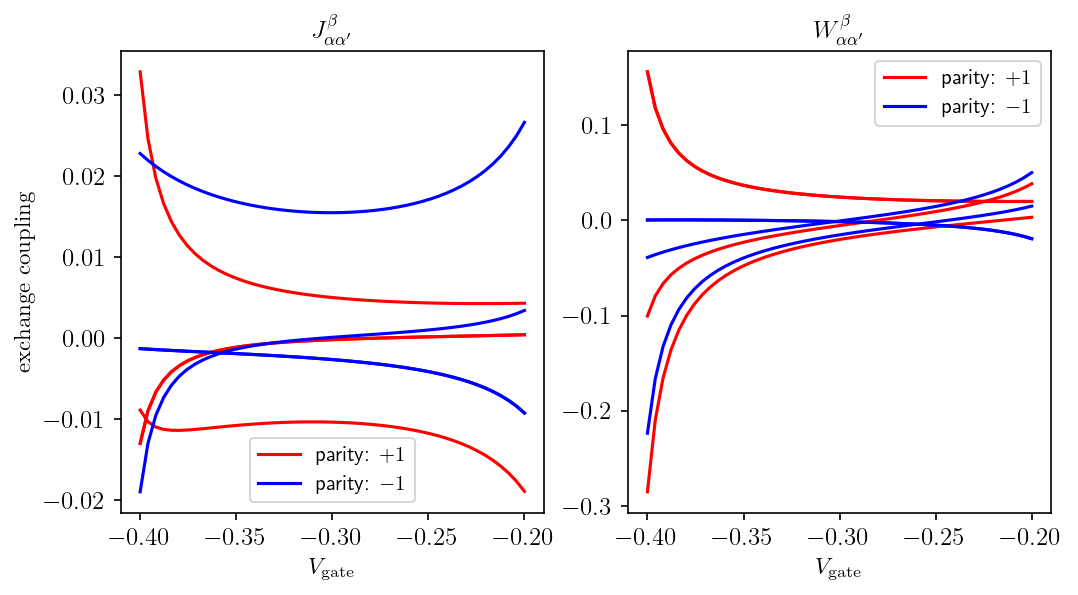

In [33]:
tickfont = 12
labelfont = 11

fig = plt.figure()
fig, bx = plt.subplots(1,2, figsize=(8,4),dpi=150)

ax = bx[0]
ax.set_title("$J^\\beta_{\\alpha\\alpha'}$",size=tickfont)

ax.plot(Vgset,Jvec[:,0,0],color='r',label="parity: $+1$")
for i in range(1,4): ax.plot(Vgset,Jvec[:,0,i],color='r')
ax.plot(Vgset,Jvec[:,1,0],color='b',label="parity: $-1$")
for i in range(1,4): ax.plot(Vgset,Jvec[:,1,i],color='b')
ax.legend(loc='best')
ax.tick_params(axis='both', which='major', labelsize=tickfont)
ax.tick_params(axis='both', which='minor', labelsize=tickfont)
ax.set_ylabel("$\\rm exchange~coupling$",fontsize=labelfont)
ax.set_xlabel("$V_{\\rm gate}$",fontsize=labelfont)
ax.tick_params(axis='y', which='major', labelsize=tickfont)
ax.tick_params(axis='y', which='minor', labelsize=tickfont)
ax.tick_params(axis='x', which='major', labelsize=tickfont)
ax.tick_params(axis='x', which='minor', labelsize=tickfont)

# Next panel
ax = bx[1]
ax.set_title("$W^\\beta_{\\alpha\\alpha'}$",size=tickfont)
ax.plot(Vgset,Wvec[:,0,0],color='r',label="parity: $+1$")
for i in range(1,4): ax.plot(Vgset,Wvec[:,0,i],color='r')
ax.plot(Vgset,Wvec[:,1,0],color='b',label="parity: $-1$")
for i in range(1,4): ax.plot(Vgset,Wvec[:,1,i],color='b')
ax.legend(loc='best')
ax.tick_params(axis='both', which='major', labelsize=tickfont)
ax.tick_params(axis='both', which='minor', labelsize=tickfont)
ax.set_xlabel("$V_{\\rm gate}$",fontsize=labelfont)
ax.tick_params(axis='y', which='major', labelsize=tickfont)
ax.tick_params(axis='y', which='minor', labelsize=tickfont)
ax.tick_params(axis='x', which='major', labelsize=tickfont)
ax.tick_params(axis='x', which='minor', labelsize=tickfont)